In [73]:
#Imports libraries, displays a piece of real spectrum data, and defines plotting functions.

#standard library
import os
import time
import random
import requests 
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Optional
from itertools import combinations, permutations

#scipy
from scipy import signal, stats, ndimage
from scipy.optimize import minimize 
from scipy.stats import truncnorm
#import scipy.signal as scipy
#import scipy.optimize as scipyo
#import scipy.optimize as optimize
#from scipy.ndimage import gaussian_filter
#from scipy.ndimage import median_filter
#from scipy.stats import multivariate_normal
#from scipy.signal import find_peaks
#from scipy.interpolate import interp1d

#plotting
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns #data visualization lib for statistical graphics
from matplotlib import cm
from matplotlib.colors import LogNorm

#machine learning
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split

#CONSTANTS
DEFAULT_PROMINENCE = 1e2
ENERGY_OFFSET = 6
ENERGY_CALIBRATION = lambda x: 0.64844 + 0.27383 * (x - 12.5)
DEFAULT_MATRIX_SIZE = 4096
DEFAULT_BIN_FACTOR = 1

## Data from GitHub ##
def load_spectrum_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")
    try:
        counts = np.array(list(map(int, response.text.split())))
    except ValueError:
        raise ValueError("Data could not be parsed to integers.")
    bins = np.arange(1, len(counts) + 1)
    energies = ENERGY_CALIBRATION(bins)
    return energies, counts
    
github_url = "https://raw.githubusercontent.com/JPittard10/Isomer-Project/refs/heads/main/Trimmed%20and%20Bunched%20Spectrums/A1_Cl37_c10_HPGe_301sec_trimmed.txt"
Energy_bin, data1_array = load_spectrum_data(github_url)

#data1 = response.text
#data1_array = np.array(list(map(int, data1.split())))
#bin_array = list(range(1,(len(data1_array)+1)))
#Energy_bin = 0.64844 + 0.27383 * np.array((np.array(bin_array)) - 12.5)
#prominence = 1e2

## PLOTTING FUNCTIONS ##

#displays spectrum data plainly without labeling peaks
def plot_func(x_data, y_data, x_label, y_label, title, x_unit, y_unit, color):
    df = pd.DataFrame({x_label: x_data, y_label: y_data})
    ax = df.plot(
        x=x_label, y=y_label, title=title,
        xlabel=f"{x_label} ({x_unit})", ylabel=f"{y_label} ({y_unit})",
        color=color, figsize=(12, 6)
    )
    plt.tight_layout()
    return ax
    
#organizes and makes sure peaks are setup properly
def plot_peaks_func(x_data, y_data, x_label, y_label, title, x_unit, y_unit,
                    color='blue', prominence=DEFAULT_PROMINENCE):
    peaks, _ = signal.find_peaks(y_data, prominence=prominence)
    peak_energies = x_data[peaks]
    peak_counts = y_data[peaks]
    sorted_indices = np.argsort(peak_counts)[::-1]

    df = pd.DataFrame({x_label: x_data, y_label: y_data})
    ax = df.plot(
        x=x_label, y=y_label, title=title,
        xlabel=f"{x_label} ({x_unit})", ylabel=f"{y_label} ({y_unit})",
        color=color, figsize=(12, 6)
    )

    for i in sorted_indices:
        x = peak_energies[i]
        y = peak_counts[i]
        ax.plot(x, y, 'ro')
        ax.text(x, y, f"{x:.1f} keV\n{int(y)}", fontsize=8,
                ha='center', va='bottom')

    plt.tight_layout()
    return np.sort(np.round(peak_energies, 1))

#plots a line on the spectrum plot where the peak was identified
def sir_peaks_plotalot(y_data, ax, prominence=DEFAULT_PROMINENCE, offset=ENERGY_OFFSET):
    peaks, _ = signal.find_peaks(y_data, prominence=prominence)
    peak_energies = ENERGY_CALIBRATION(peaks) + offset
    for energy in peak_energies:
        ax.axvline(x=energy, color='red', alpha=0.3)
    return peaks

#displays energy of peaks & respective counts from greatest to largest 
def sir_peaks_displayalot(y_data, label, prominence=DEFAULT_PROMINENCE, offset=ENERGY_OFFSET):
    peaks, _ = signal.find_peaks(y_data, prominence=prominence)
    peak_energies = ENERGY_CALIBRATION(peaks) + offset
    peak_counts = y_data[peaks]
    sorted_indices = np.argsort(peak_counts)[::-1]

    print(f"Sorted Peaks For Plot '{label}'")
    print("Peak Energy (keV) | Counts")
    print("-----------------------------")
    for i in sorted_indices:
        print(f"{peak_energies[i]:<17.3f} | {peak_counts[i]:<10.0f}")

    print("\nPlot Peaks (left to right):")
    for energy in np.sort(peak_energies):
        print(f"{energy:.3f}")
    print("-----------------------------\n")

#plots function ladders
def plot_func_ladders(x_data, y_series, x_label, y_label, title, x_unit, y_unit, cmap='tab10'):
    df_data = {x_label: x_data}
    for i, y in enumerate(y_series):
        df_data[f"{y_label}_{i+1}"] = y
    df = pd.DataFrame(df_data)
    colors = get_nice_colors(len(y_series), cmap)
    y_cols = [f"{y_label}_{i+1}" for i in range(len(y_series))]

    ax = df.plot(
        x=x_label, y=y_cols, title=title,
        xlabel=f"{x_label} ({x_unit})", ylabel=f"{y_label} ({y_unit})",
        color=colors, figsize=(12, 6)
    )
    plt.tight_layout()
    return ax

#generates "n" random colors 
def get_nice_colors(n, cmap_name='tab10'):
    cmap = plt.cm.get_cmap(cmap_name)
    return [cmap(i % cmap.N) for i in range(n)]

#chooses a random color from CSS4 pool
def get_random_named_color():
    return random.choice(list(mcolors.CSS4_COLORS.keys()))

### LEVEL SCHEME PLOTTING ###
# Purpose: plots level bands + arrays
def plot_level_bands(bands, spacing=3, line_length=0.5, label_offset=0.6, energy_offset=0.3):
    plt.figure(figsize=(spacing * len(bands), 10))  # increased vertical size
    ax = plt.gca()

    for i, band in enumerate(bands):
        x_offset = i * spacing
        nodes = band["nodes"]
        edges = band["edges"]

        for label, energy in nodes.items():
            ax.hlines(y=energy,
                      xmin=x_offset - line_length / 2,
                      xmax=x_offset + line_length / 2,
                      color='black', linewidth=2)
            # labels
            ax.text(x_offset + label_offset, energy, label,
                    va='center', ha='left', fontsize=11, fontweight='bold')

        # transitions
        for u, v in edges:
            y_start = nodes[u]
            y_end = nodes[v]
            mid_y = (y_start + y_end) / 2
            delta_E = y_start - y_end

            ax.annotate("",
                        xy=(x_offset, y_end),
                        xytext=(x_offset, y_start),
                        arrowprops=dict(arrowstyle="->", lw=1.5))
            ax.text(x_offset - energy_offset, mid_y, f"{delta_E:.1f} keV",
                    fontsize=9, va='center', ha='right')
        # band label
        top_energy = max(nodes.values())
        ax.text(x_offset, top_energy + 100, band["name"],
                ha='center', va='bottom', fontsize=13, fontweight='bold')

    # formatting
    max_energy = max(max(b["nodes"].values()) for b in bands)
    ax.set_ylim(-50, max_energy + 200)  # more space on top
    ax.set_xlim(-1, len(bands) * spacing)
    ax.set_title("Level Scheme", fontsize=16, pad=40)  # padded title
    ax.axis('off')
    plt.show()  # removed tight_layout to avoid clipping title


# === Example Usage  === #
# ax = plot_func(Energy_bin, data1_array, 'Energy', 'Counts', 'Raw Spectrum', 'keV', 'Counts', 'blue')
# peaks = sir_peaks_plotalot(data1_array, ax)
# sir_peaks_displayalot(data1_array, 'Raw Spectrum')

#should plot based on FHWM
#------------ rel_height at 0.3 for background -------------#
#width, width_heights, left_ips, right_ips = scipy.peak_widths(data1_array, peaks_raw_spec, rel_height=0.3)
#print(len(bin_array), len(Energy_bin))


Sorted Peaks For Plot 'Cl-37 Raw Spectrum'
Peak Energy (keV) | Counts
-----------------------------
162.321           | 5715      
90.577            | 1866      
61.278            | 1361      
70.588            | 595       
105.364           | 527       
140.688           | 515       
142.879           | 515       
194.907           | 515       
513.645           | 510       
892.078           | 497       
80.446            | 457       
237.898           | 425       
352.633           | 423       
169.714           | 416       
1287.762          | 412       
261.721           | 342       
31.978            | 341       
298.140           | 272       
612.223           | 268       
1122.916          | 248       
849.360           | 244       
1095.533          | 225       
699.028           | 206       
820.060           | 206       
1159.610          | 184       
1306.930          | 180       
785.832           | 151       
786.379           | 151       
928.223           | 151       



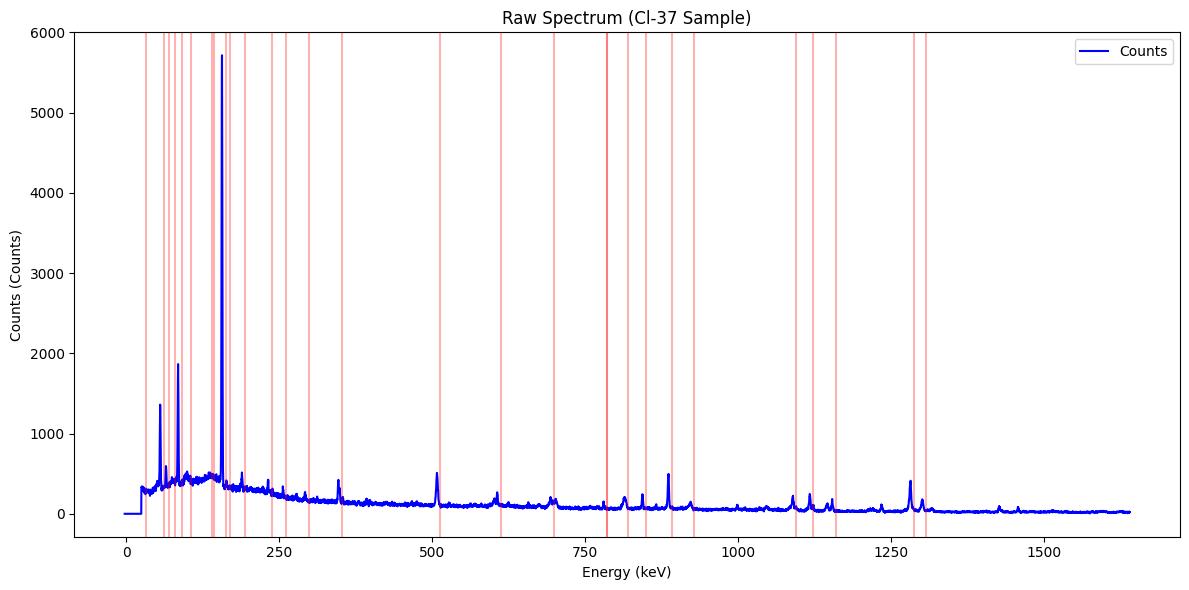

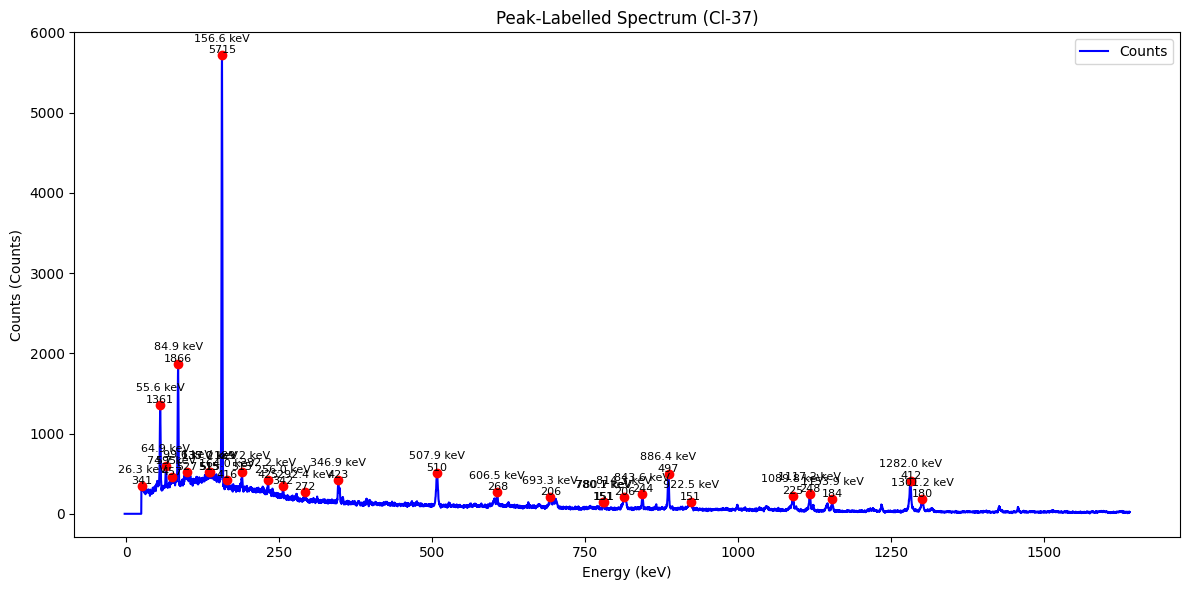

In [74]:
#Demo Code to run above cell 

#load spectrum data
Energy_bin, data1_array = load_spectrum_data(
    "https://raw.githubusercontent.com/JPittard10/Isomer-Project/refs/heads/main/Trimmed%20and%20Bunched%20Spectrums/A1_Cl37_c10_HPGe_301sec_trimmed.txt"
)

#plot raw spectrum
raw_ax = plot_func(
    Energy_bin, data1_array,
    x_label='Energy',
    y_label='Counts',
    title='Raw Spectrum (Cl-37 Sample)',
    x_unit='keV',
    y_unit='Counts',
    color='blue'
)

#overlay vertical lines at detected peaks
peaks_indices = sir_peaks_plotalot(
    y_data=data1_array,
    ax=raw_ax,
    prominence=1e2
)

#print peak energies & their counts
sir_peaks_displayalot(
    y_data=data1_array,
    label="Cl-37 Raw Spectrum",
    prominence=1e2
)

#(Optional) Generate a more detailed peak-annotated plot
peak_labels = plot_peaks_func(
    x_data=Energy_bin,
    y_data=data1_array,
    x_label='Energy',
    y_label='Counts',
    title='Peak-Labelled Spectrum (Cl-37)',
    x_unit='keV',
    y_unit='Counts',
    color='blue',
    prominence=1e2
)


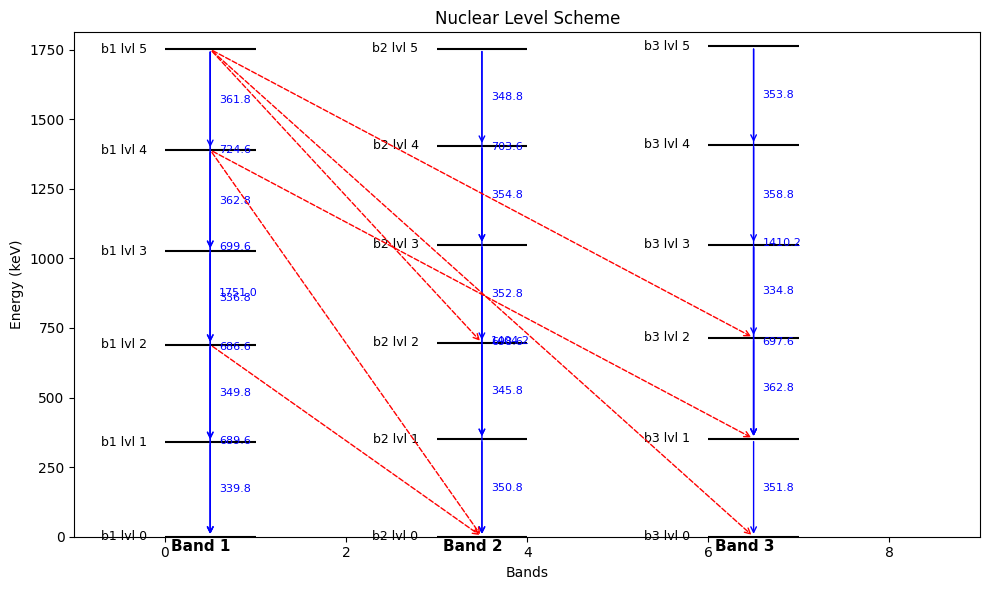

In [126]:
#1D plot building functions - Ace Rounds

#CONSTANTS
CALIB_OFFSET = 1.785
CALIB_SLOPE = 0.99943
FWHM_TO_STD = 0.27383

MIN_WIDTH = 1.0
DEFAULT_WIDTH_MEAN = 2.5
DEFAULT_WIDTH_STD = 0.9
DEFAULT_MATRIX_SIZE = 4096

energy_axis = CALIB_OFFSET + CALIB_SLOPE * np.arange(DEFAULT_MATRIX_SIZE)

#Converts gamma transitions into level scheme
class Band:
    def __init__(self, band_id: int, gamma_energies: List[float], branching_prob: float = 0.3):
        self.band_id = band_id
        self.levels = self.linear_gamma_to_levels(gamma_energies)
        #self.nodes = {f'L{i}': lvl for i, lvl in enumerate(self.levels)}
        self.nodes = {f'L{band_id}_{i}': lvl for i, lvl in enumerate(self.levels)}
        self.edges = self.generate_edges(branching_prob)

    @staticmethod
    def linear_gamma_to_levels(gamma_energies: List[float]) -> List[float]:
        E_top = sum(gamma_energies)
        return [E_top - sum(gamma_energies[:i]) for i in range(len(gamma_energies) + 1)]
    
    def generate_edges(self, branching_prob: float) -> List[Tuple[str, str]]:
        edges = []
        n = len(self.levels)
        keys = list(self.nodes.keys())
        for i in range(1, n):
            # always include linear decay
            edges.append((keys[i], keys[i - 1]))
            # add branching to lower levels
            for j in range(i - 2, -1, -1):
                if np.random.rand() < branching_prob:
                    edges.append((keys[i], keys[j]))
        return edges


#Ladder generator
#Generates ladder of gamma-ray transitions
class Ladder:
    def __init__(self, max_rungs: int = 3, spacing: int = 350, jitter: int = 15):
        self.max_rungs = max_rungs
        self.spacing = spacing
        self.jitter = jitter
        self.positions = []

    def generate_ladder(self):
        self.positions = [0]
        for _ in range(self.max_rungs):
            step = self.spacing + np.random.randint(-self.jitter, self.jitter)
            self.positions.append(self.positions[-1] + step)

#Cross Branching
def add_interband_branching(bands: List[Dict], max_connections: int = 5, prob: float = 0.3) -> List[Tuple[Tuple[int, str], Tuple[int, str]]]:
    cross_edges = []
    for i, band_a in enumerate(bands):
        for j, band_b in enumerate(bands):
            if i >= j:
                continue  # avoid self or duplicates

            for src_lbl, src_E in band_a["nodes"].items():
                for tgt_lbl, tgt_E in band_b["nodes"].items():
                    if src_E > tgt_E and np.random.rand() < prob:
                        edge = ((i, src_lbl), (j, tgt_lbl))
                        cross_edges.append(edge)
                        if len(cross_edges) >= max_connections:
                            return cross_edges
    return cross_edges

#Level band plotter
def plot_level_bands(bands: List[Dict], cross_edges: List[Tuple[Tuple[int, str], Tuple[int, str]]] = None, title: str = "Nuclear Level Scheme"):
    fig, ax = plt.subplots(figsize=(10, 6))
    y_margin = 50
    x_spacing = 3.0

    for i, band in enumerate(bands):
        nodes = band["nodes"]
        edges = band["edges"]
        x_offset = i * x_spacing

        #Labels each band
        ax.text(x_offset + 0.4, -y_margin, f"Band {i + 1}", ha='center', fontsize=11, weight='bold')
        
        # Sort levels by increasing energy to label from ground up
        sorted_levels = sorted(nodes.items(), key=lambda x: x[1])
        for level_idx, (label, energy) in enumerate(sorted_levels):
            ax.hlines(energy, x_offset, x_offset + 1, color='black')
            ax.text(x_offset - 0.2, energy, f"b{i+1} lvl {level_idx}", va='center', ha='right', fontsize=9)

        # Plot levels
        #for label, energy in nodes.items():
           # ax.hlines(energy, x_offset, x_offset + 1, color='black')
           # ax.text(x_offset + 1.1, energy, f'{energy:.1f}', va='center', fontsize=9)

        # Plot transitions
        #if src in nodes and dst in nodes:
        for src, dst in edges:
                y1, y2 = nodes[src], nodes[dst]
                if y1 < y2:
                    y1, y2 = y2, y1
                x = x_offset + 0.5
                ax.annotate("", xy=(x, y2), xytext=(x, y1),
                            arrowprops=dict(arrowstyle='->', color='blue'))

        # Draw energy labels centered next to transitions
        for src, dst in edges:
            if src in nodes and dst in nodes:
                y1, y2 = nodes[src], nodes[dst]
                energy_diff = abs(y1 - y2)
                x = x_offset + 0.6
                y_mid = (y1 + y2) / 2
                ax.text(x, y_mid, f"{energy_diff:.1f}", va='center', fontsize=8, color='blue')

    if cross_edges:
        for (i, src), (j, dst) in cross_edges:
            x1 = i * x_spacing + 0.5
            x2 = j * x_spacing + 0.5
            y1 = bands[i]["nodes"][src]
            y2 = bands[j]["nodes"][dst]
            ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                        arrowprops=dict(arrowstyle='->', color='red', linestyle='dashed'))

    ax.set_xlabel("Bands")
    ax.set_ylabel("Energy (keV)")
    ax.set_title(title)
    ax.set_xlim(-1, len(bands) * x_spacing)
    ax.set_ylim(0, max([max(band["nodes"].values()) for band in bands]) + y_margin)
    #ax.invert_yaxis()
    ax.grid(False)
    plt.tight_layout()
    plt.show()

#Simulate 2D Matrix
def simulate_2D_matrix(num_peaks: int = 10, bin_factor: int = DEFAULT_BIN_FACTOR,
                       matrix_size: int = DEFAULT_MATRIX_SIZE) -> np.ndarray:
    matrix = np.zeros((matrix_size, matrix_size))

    for _ in range(num_peaks):
        x = np.random.randint(0, matrix_size)
        y = np.random.randint(0, matrix_size)
        amp = random.uniform(500, 1e5)
        sigma = random_width(x, matrix_size=matrix_size)

        for i in range(max(0, x - 3 * int(sigma)), min(matrix_size, x + 3 * int(sigma))):
            for j in range(max(0, y - 3 * int(sigma)), min(matrix_size, y + 3 * int(sigma))):
                val = amp * np.exp(-((i - x) ** 2 + (j - y) ** 2) / (2 * sigma ** 2))
                matrix[i, j] += val

    return matrix

#Random Width Generator
def random_width(x: int = 0, matrix_size: int = DEFAULT_MATRIX_SIZE) -> float:
    E_scale = 1 + (2 * x / matrix_size)
    loc = 2.5 * E_scale
    scale = 0.9
    a = (1.0 - loc) / scale
    b = np.inf
    from scipy.stats import truncnorm
    trunc = truncnorm(a, b, loc=loc, scale=scale)
    return trunc.rvs()

#Plot 1D Spectrum
def plot_peaks_func(
    x: np.ndarray,
    y: np.ndarray,
    title: str = 'Gamma Spectrum',
    xlab: str = 'Energy (keV)',
    ylab: str = 'Counts',
    color: str = 'blue',
    prominence: float = 1e2
):
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, color=color, linewidth=1.2)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Main
if __name__ == "__main__":
    bands = []
    for i in range(3):
        ladder = Ladder(max_rungs=5)
        ladder.generate_ladder()
        gammas = [energy_axis[ladder.positions[j + 1]] - energy_axis[ladder.positions[j]]
                  for j in range(len(ladder.positions) - 1)]
        band = Band(band_id=i, gamma_energies=gammas, branching_prob=0.4)
        bands.append({
            "name": f"Band {i}",
            "nodes": band.nodes,
            "edges": band.edges
        })

    cross = add_interband_branching(bands, max_connections=6, prob=0.3)

    plot_level_bands(bands, cross_edges=cross)


In [127]:
#Prints 2D Gamma-ray Coinc matrix plot from above cell
matrix, bands = simulate_2D_matrix(seed=42, num_ladders=3, max_rungs=4)
TwoDPlot(matrix)


TypeError: simulate_2D_matrix() got an unexpected keyword argument 'seed'

In [117]:
#Plots 1D spectrum from the bands
energy_axis = CALIB_OFFSET + CALIB_SLOPE * (np.arange(DEFAULT_MATRIX_SIZE))

ladder = Ladder(DEFAULT_MATRIX_SIZE)
ladder.generate_ladder()

# Create empty spectrum with zeros
data_array = np.zeros(DEFAULT_MATRIX_SIZE)

# Insert ladder heights at specified positions
for i, pos in enumerate(ladder.positions):
    if pos < DEFAULT_MATRIX_SIZE:
        data_array[pos] = ladder.heights[i]
        
y_values = peak_inserter(energy_axis, ladder.positions, ladder.widths, data_array)
plot_peaks_func(energy_axis, y_values, "", "", "Simulated 1D Spectrum", "Energy (keV)", "Counts", "purple")


AttributeError: 'Ladder' object has no attribute 'heights'

In [118]:
# 1D plot building functions - Mason Levere

# --- Constants ---
CALIB_OFFSET = 1.785
CALIB_SLOPE = 0.99943
FWHM_TO_STD = 0.27383

MIN_WIDTH = 1.0
DEFAULT_WIDTH_MEAN = 2.5
DEFAULT_WIDTH_STD = 0.9

# Purpose: creates a gaussian
def gaussian_peak(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    
# Purpose: generate y-values of gaussian peaks based off of real spectroscopy data (1D)
def peak_inserter(Energy_bin, peaks, width, data1_array):
    num_peaks = len(peaks)
    just_peaks = np.zeros(len(Energy_bin))
    print(peaks)
    for i in range(len(peaks)):
        peak_index = peaks[i]
        peak_height = data1_array[peak_index]
        sd = width[i]/2
        left = np.int64(np.ceil(peak_index - ((2*width[i])/0.27383)))
        right = np.int64(np.ceil(peak_index + ((2*width[i])/0.27383)))
        x_range = np.array(range(left, right))
        gaussian_part = gaussian_peak(x_range, peak_height, x_range[int((right-left)/2)], sd)
        int_indices = np.clip(np.round(x_range).astype(int), 0, len(just_peaks) - 1)
        np.add.at(just_peaks, int_indices, gaussian_part)
        
    return just_peaks

# Purpose: generates arrays for ladders seperately  
#also gives boundaries & integrals of the 1D peaks
def peak_inserter_ladder(Energy_bin, peaks, peak_height, width):
    peak_arrays = []
    boundaries = []
    integrals = []
    for j in range(len(peaks)): 
        num_peaks = len(peaks[j])
        just_peaks = np.zeros(len(Energy_bin))
        boundary = []
        integral = []
        for i in range(len(peaks[j])):
            peak_index = peaks[j][i]
            peak_height_num = peak_height[j][i]
            sd = width[j][i]/2
            left = np.int64(np.ceil(peak_index - ((width[j][i])/0.27383)))
            right = np.int64(np.ceil(peak_index + ((width[j][i])/0.27383)))
            x_range = np.array(range(left, right))

            gaussian_part = gaussian_peak(x_range, peak_height_num, x_range[int((right-left)/2)], sd)
            int_indices = np.round(x_range).astype(int)
            int_indices = np.clip(int_indices, 0, len(just_peaks) - 1)
            np.add.at(just_peaks, int_indices, gaussian_part)
            
            total_counts = np.int64(np.sum(gaussian_part))
            boundary.append([left, right])
            integral.append(total_counts)
        peak_arrays.append(just_peaks)
        boundaries.append(boundary)
        integrals.append(integral)
       
    return(peak_arrays, boundaries, integrals)


# Purpose: takes multiple ladders in 1D and shows their sum
def add_ladders(ladders):
    matrix = np.sum(ladders, axis = 0)
    return(matrix)

# 1D and 2D ladder parameter functions


# Purpose: Creates the positions, heights, and widths for a ladder within a given range of x values. 
# If the ladder is out of bounds, it resets and tries again. By default, it will generate a ldadder based on random parameters, 
# but parameters can be passed to fix certain values.
# It also generates random values for ground decay.

def generate_ladder(Energy_bin, width, ground, accuracy, rungs=None, x0=None, y0=None, d0=None, size=4096):
    if rungs == None:
        rungs = np.random.randint(3, 5)
    if x0 == None:
        x0 = np.random.randint(30, (size-30))
    if y0 == None:
        y0 = np.random.randint(5000, 50000)
    if d0 == None:
        d0 = np.int64(np.random.randint(30, 600))
    
    # widths made bigger for now
    positions = [x0]
    heights = [y0]
    #widths = [np.int64(np.random.normal(np.mean(width), accuracy))*5]
    widths = [random_width(x0)]

    for j in range(1, rungs):
        rung_index = positions[j - 1] + np.int64(d0 * np.random.normal(1, accuracy))
        if (rung_index >= 4096) or (rung_index <= 0) : # -30 to prevent plotting on the edge
            return None  # failed ladder
        rung_height = np.int64(heights[j - 1] * np.random.uniform(0.5, 0.9))
        # width changed here too
        #rung_width = np.int64(np.random.normal(np.mean(width), accuracy)) * 5
        rung_width = random_width(x=rung_index)

        positions.append(rung_index)
        heights.append(rung_height)
        widths.append(rung_width)

    # ground transition (WIP)
    if ground:
        ground_transition_energy = np.random.randint(0, 4096)
        ground_tranisition_intensity = np.int64(2 * max(heights))
        #ground_tranisition_width = np.int64(np.random.normal(np.mean(width), accuracy))*5
        ground_tranisition_width = random_width()
        positions.insert(0, ground_transition_energy)
        heights.insert(0, ground_tranisition_intensity)
        widths.insert(0, ground_tranisition_width)

    return positions, heights, widths



#### WEIRD but works

def snake_ladder(positions, heights, widths, rungs, threshold=0.3, size=4096):
        positions_lst = []
        heights_lst = []
        widths_lst = []
        i = 1
        while True: # one band feature, keeps running until failure
            chance = random.uniform(0, 1) 
            if chance < threshold:
                #index = random.randint(0, len(positions)-1) random index
                index = len(positions)-1 #last index (last was ground, now first is)
                x0 = positions[index] 
                y0 = heights[index]
                d0 = (np.random.randint(30, 600)) * ((-1)**i) # term is negative for odd i, positive for even i
                # needs to be put back as variables
                result = generate_ladder(Energy_bin, random_width(x0), 0, 0.02, rungs, x0, y0, d0, size)
                if result is not None:
                    positions, heights, widths = result

                    positions_lst.extend(positions[1:])
                    heights_lst.extend(heights[1:])
                    widths_lst.extend(widths[1:])
                    i += 1
                    if i == 3:
                    # can only snake back twice
                        break
                else:
                    #print(f"Failed after {i} attempts")
                    break
        return positions_lst, heights_lst, widths_lst


# Name: Peak_ladder
# Purpose: generates multiple ladders and outputs their parameters
# Creator: Mason Levere
# Function: peak_ladder(number of ladders, accuracy of detector, chance of a 'split' (idea of split needs work), width (default to 5 for convenience)

def peak_ladder(num_ladders, accuracy, max_rungs, threshold=0.8, width=20, size=4096):
    width = 20
    peak_index = []
    peak_height = []
    peak_width = []

    i = 0
    while i < num_ladders:
        result = generate_ladder(Energy_bin, width, 1, accuracy, max_rungs, size=size)

        if result is not None:
            positions, heights, widths = result

            peak_index_temp = positions.copy()
            peak_height_temp = heights.copy()
            peak_width_temp = widths.copy()

            # Try to extend the band with a snake branch
            if threshold > random.random():
                result2 = snake_ladder(positions, heights, widths, max_rungs, threshold=threshold, size=size)
                if result2 is not None:
                    positions_lst, heights_lst, widths_lst = result2
                    peak_index_temp.extend(positions_lst)
                    peak_height_temp.extend(heights_lst)
                    peak_width_temp.extend(widths_lst)

            # Only add results if the main ladder was successfully created
            peak_index.append(peak_index_temp)
            peak_height.append(peak_height_temp)
            peak_width.append(peak_width_temp)

            i += 1  # Only count if the core ladder is valid
        else:
            #print("generate_ladder failed, retrying...")
            x = 0

    return peak_index, peak_height, peak_width


# Name: made_dict
# Purpose: make a dictionary given two lists of same dimension
# Creator: Mason Levere
# Function: make_dict(list of keys, corresponding list of values)

def make_dict(keys, values):
    return dict(zip(keys, values))

# Name: TwoDParameters
# Purpose: generates coordinates, amplitudes, and widths of peaks for a 2D matrix
# Creator: Mason Levere
# Function: TwoDParameters(list of lists of peak_indexs, list of lists for coincidences (this is taken from 
# the visual of a level scheme, counts are proportional to amplitudes due to plotting within a set sd), list of lists of peak widths)


def TwoDParamaters(peak_index, peak_height, peak_width):
    peak_index_parameter = []
    peak_height_parameter = []
    peak_width_parameter = []
    for i in range(len(peak_index)):
        lst_index = peak_index[i]
        lst_height = peak_height[i]
        lst_width = peak_width[i]
        
        lst_height_width = list(zip(lst_height, lst_width))
        index_height_dic = make_dict(lst_index, lst_height_width)
        coordinates = list(permutations(lst_index, 2))
        heights = [min([index_height_dic[item][0] for item in tup]) for tup in coordinates]
        widths = [tuple(index_height_dic[x][1] for x in tup) for tup in coordinates]
        
        peak_index_parameter.append(coordinates)
        peak_height_parameter.append(heights)
        peak_width_parameter.append(widths)
         
    peak_index_parameter = [tup for sublist in peak_index_parameter for tup in sublist]
    peak_height_parameter = [item for sublist in peak_height_parameter for item in sublist]
    peak_width_parameter = [tup for sublist in peak_width_parameter for tup in sublist]

    return(peak_index_parameter, peak_height_parameter, peak_width_parameter)
    
# 2D Functions

# Name: GateVertical
# Purpose: takes a vertical gate of a 2D matrix
# Creator: Mason Levere
# Function: GateVertical(2D matrix, center of gate, width from center of gate)

def GateVertical(matrix, energy, gate_width = 60):
    channel = EnergytoChannel(energy)
    gate_width = EnergytoChannel(gate_width)
    arrays = (matrix[:][(channel-gate_width):(channel+gate_width)])
    array = np.sum(arrays, axis=0)
    return(array)

# Name: GateHorizontal
# Purpose: takes a horizontal gate of a 2D matrix
# Creator: Mason Levere
# Function: GateHorizontal(2D matrix, center of gate, width from center of gate)

def GateHorizontal(matrix, energy, gate_width = 60):
    channel = EnergytoChannel(energy)
    gate_width = EnergytoChannel(gate_width)    
    arrays = (matrix[(channel-gate_width):(channel+gate_width)][:])
    array = np.sum(arrays, axis=0)
    return(array)
    
# Name: EnergytoChannel
# Purpose: takes an energy and converts to a channel index
# Creator: Mason Levere
# Function: EnergytoChannel(energy)

def EnergytoChannel(energy):
    channel_number = np.int64((energy-1.785)/0.99943)
    
    return(channel_number)

# Name: Gate
# Purpose: Gate on a 2D matrix given a center energy and width
# Creator: Mason Levere
# Function: Gate(2D matrix)

def Gate(matrix, bin_factor=1): 
    N_full = 4096
    while True:
        gate_input = input('Gate Energy? (return to escape)')
        if gate_input == '':
            break
        else:
            gate = int(gate_input)
        width_input = input('Width (default of 20 keV): ')
        if width_input == '':
            width = 20
        else:
            width = int(width_input)
        x1 = GateVertical(matrix, gate, width)
        N = np.shape(matrix)[0]
        energy_axis = (1.785 + (0.99943 * (np.arange(N) * bin_factor)))      
        Energy_bin = energy_axis
        plot_peaks_func(Energy_bin, x1, 'Energy', 'Counts', f'Gate at {gate}kEv from {gate-width} to {gate+width}', 'Energy (keV)', 'Counts', 'blue')
        plt.show()

# Name: TotalProjection
# Purpose: gives a 1D coincidence view of a 2D matrix by summing down on the rows
# Creator: Mason Levere
# Function: TotalProjection(2D matrix)


def TotalProjection(matrix, peak_display = 1, bin_factor=1, title='Total Projection', prominence=prominence):
    N = matrix.shape[0]
    array = np.sum(matrix, axis=0)

    # Do NOT scale center shift — keep it fixed to match calibration
    center_shift = 12.5
    energy_axis = 1.785 + (0.99943 * (np.arange(N)*bin_factor))
    
    if peak_display:
        return plot_peaks_func(energy_axis, array, 'Energy', 'Counts', title, 'Energy (keV)', 'Counts', 'blue', prominence)
    else:
        return plot_func(energy_axis, array, 'Energy', 'Counts', title, 'Energy (keV)', 'Counts', 'blue')
#need better gating width

def band_maker(gammas_lst, bin_factor = 1):
    bands = []
    for i in range(len(gammas_lst)):
        peak_energy = gammas_lst[i]
        levels = linear_gamma_to_levels(peak_energy)
        levels[0] = 0
        node_labels = ['grnd']
        for j in range(len(levels)-1):
            node_labels.append(f'b{i+1} lvl{j+1}')
        
        nodes_dict = dict(zip(node_labels, levels))
        node_labels_reversed = node_labels[::-1]
        edge_tups = [(a, b) for a, b in zip(node_labels_reversed, node_labels_reversed[1:])]

        
        band_info = dict(name = f'Band {i+1}', nodes = nodes_dict, edges = edge_tups)
        bands.append(band_info)
    
    return(bands)

# example of formatting
#bands = [
#    {
#        "name": "Band 1",
#        "nodes": {"g": 0, "a": 100, "b": 300, "c": 600},
#        "edges": [("c", "b"), ("b", "a"), ("a", "g")]
#    },
#    {
#        "name": "Band 2",
#        "nodes": {"g": 0, "x": 150, "y": 400, "z": 700},
#        "edges": [("z", "y"), ("y", "x"), ("x", "g")]
#    }
#]


def linear_gamma_to_levels(gammas):
    levels = [0]
    for i in range(1, len(gammas)+1):
        levels.append(np.sum(gammas[0:i]))
    return(levels)




def simulate_2D_matrix(seed, max_rungs, bin_factor=1, cutoff_sigma=3, plot=True, num_ladders=1):
    rng_np = np.random.default_rng(seed)
    rng_py = random.Random(seed)
    start_time = time.perf_counter()

    def scaled_index_to_energy(index):
        return 1.785 + (0.99943 * (index * bin_factor))

    
    count_lst = []
    count_lst2 = []
    N_full = 4096
    N = N_full // bin_factor
    energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))
    X, Y = np.meshgrid(energy_axis, energy_axis)
    matrix = np.zeros((N, N), dtype=np.float32)
    
    # number of peaks in a matrix (can be fixed)
    peak_index, peak_height, peak_width = peak_ladder(num_ladders, 0.02, max_rungs, N_full, threshold=0.3) #3 is number of rungs per band segment)
    peak_index_parameter, peak_height_parameter, peak_width_parameter = TwoDParamaters(peak_index, peak_height, peak_width)

    peak_index_ls = [
    [scaled_index_to_energy(i // bin_factor) for i in sublist]
    for sublist in peak_index
]


    scaled_index = [(i[0] // bin_factor, i[1] // bin_factor) for i in peak_index_parameter]
    scaled_width = [(w[0] / bin_factor, w[1] / bin_factor) for w in peak_width_parameter]
    print(scaled_width, 'scaled width')

    centers_x = [scaled_index_to_energy(t[0]) for t in scaled_index]
    centers_y = [scaled_index_to_energy(t[1]) for t in scaled_index]
    sigmas_x = [0.27383 * (t[0] / 5) for t in scaled_width]
    sigmas_y = [0.27383 * (t[1] / 5) for t in scaled_width]

    amplitudes = peak_height_parameter

    for x0, y0, sx, sy, A in zip(centers_x, centers_y, sigmas_x, sigmas_y, amplitudes):
        #print(x0, y0, sx, sy, A)
        #print(x0)
        xmin = max(0, np.searchsorted(energy_axis, x0 - cutoff_sigma * sx))
        xmax = min(N, np.searchsorted(energy_axis, x0 + cutoff_sigma * sx))
        ymin = max(0, np.searchsorted(energy_axis, y0 - cutoff_sigma * sy))
        ymax = min(N, np.searchsorted(energy_axis, y0 + cutoff_sigma * sy))

        if xmax <= xmin or ymax <= ymin:
            continue

        X_sub = X[ymin:ymax, xmin:xmax]
        Y_sub = Y[ymin:ymax, xmin:xmax]
        G = A * np.exp(-(((X_sub - x0)**2) / (2 * sx**2) + ((Y_sub - y0)**2) / (2 * sy**2)))
        matrix[ymin:ymax, xmin:xmax] += G.astype(np.float32)
        dx = np.mean(np.diff(energy_axis))
        dy = dx  # assuming square bins

# Then scale your numerical sum:
        

        count_lst.append(np.sum(G) * dx * dy)
        a = cutoff_sigma * sx
        b = cutoff_sigma * sy
        x = truncated_2d_gaussian_area(A, sx, sy, a, b)
        full_area = A * 2 * np.pi * sx * sy
        count_lst2.append([x, full_area])
        

    matrix *= 100 # for scaling with bg
    matrix += 1  # Prevent log(0) in plot
    #print(count_lst)
    #print('2', count_lst2)

    if plot:
        plt.imshow(matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
        plt.colorbar(label="Intensity")
        plt.title(f"2D Gaussian Matrix with Energy Axis (bin_factor = {bin_factor})")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Energy (keV)")
        plt.axis('equal')
        plt.show()

    level_scheme = band_maker(peak_index_ls, bin_factor)



    return(matrix, level_scheme)


def TwoDPlot(matrix, title='2D Plot', bin_factor=1):
    N = matrix.shape[0]
    energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))
    
    # Set up tick positions
    tick_start = int(np.ceil(energy_axis[0] / 500)) * 500
    tick_end = int(np.floor(energy_axis[-1] / 500)) * 500
    ticks = np.arange(tick_start, tick_end + 1, 500)

    plt.figure()
    plt.imshow(matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
               extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
    plt.colorbar(label="Intensity")
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Energy (keV)")
    plt.title(title)
    plt.show()


def random_width(x=0):
    E_scale = 1 + ((2*x)/4096)
    while True:  
        w = np.random.normal(loc=2.5, scale=0.9)
        if w > 1:
            return(w*E_scale)

def compress_matrix(matrix, bin_factor):
    """
    Compress a square matrix by averaging blocks, then scaling up
    so the total projection (sum) is preserved and energy axis range stays consistent.
    
    Parameters:
    - matrix: 2D numpy array (e.g., 4096x4096)
    - bin_factor: int, must evenly divide the matrix dimensions

    Returns:
    - compressed_matrix: downsampled 2D numpy array
    """
    N = matrix.shape[0]
    if N % bin_factor != 0:
        raise ValueError("Matrix size must be divisible by bin_factor")

    # Block average
    compressed_matrix = matrix.reshape(
        N // bin_factor, bin_factor,
        N // bin_factor, bin_factor
    ).mean(axis=(1, 3))

    # Scale up to preserve total projection
    compressed_matrix *= bin_factor

    return compressed_matrix


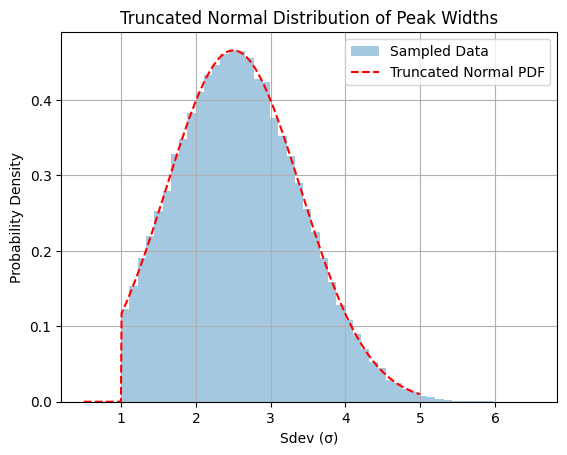

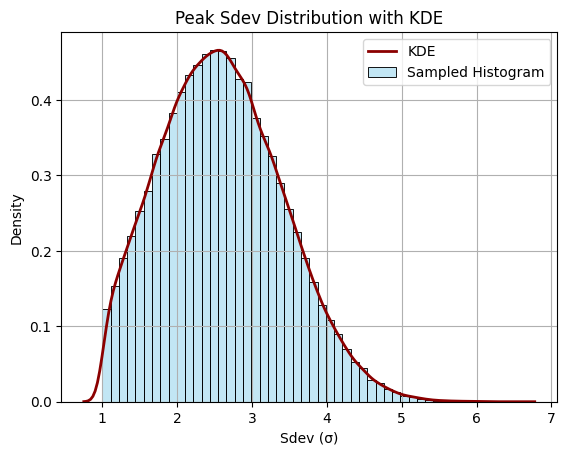

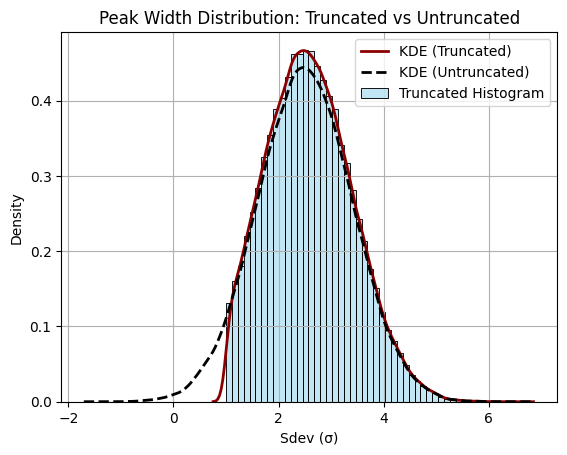

In [79]:
#Prob dist for peak width sdevs

#constants
loc = 2.5
scale = 0.9
MIN_WIDTH = 1.0 #prevents magic numbers 

#truncated normal
#a = (MIN - loc)/scale, b = ∞
a, b = (MIN_WIDTH - loc) / scale, np.inf
trunc_dist = truncnorm(a=a, b=b, loc=loc, scale=scale)

#create random seed for reproducibility
np.random.seed(42)
#samples = trunc_dist.rvs(100000)
samples = np.random.normal(loc=loc, scale=scale, size=100000)
samples = samples[samples > MIN_WIDTH] #avoid magic numbers 


#standard plot
x = np.linspace(0.5, 5, 500)
plt.hist(samples, bins=50, density=True, alpha=0.4, label='Sampled Data')
plt.plot(x, trunc_dist.pdf(x), 'r--', label='Truncated Normal PDF') #prob density func (PDF)
plt.title('Truncated Normal Distribution of Peak Widths')
plt.xlabel('Sdev (σ)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

#Kernel density estimation (KDE) plot with histogram, utilizes seaborn
#KDE estimates PDF of random var - good for identifying patterns
    #sns.histplot(samples, bins=50, kde=True, stat='density', color='skyblue')
    #plt.figure(figsize=(8, 5))
sns.histplot(samples, bins=50, stat='density', color='skyblue', alpha=0.5, label='Sampled Histogram')
sns.kdeplot(samples, color='darkred', linewidth=2, label='KDE')
plt.title('Peak Sdev Distribution with KDE')
plt.xlabel('Sdev (σ)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

#Comparison between two plots 
samples_untruncated = np.random.normal(loc=loc, scale=scale, size=100000)
samples_truncated = samples_untruncated[samples_untruncated > MIN_WIDTH]

sns.histplot(samples_truncated, bins=50, stat='density', color='skyblue', alpha=0.5, label='Truncated Histogram')
sns.kdeplot(samples_truncated, color='darkred', linewidth=2, label='KDE (Truncated)')
sns.kdeplot(samples_untruncated, color='black', linestyle='--', linewidth=2, label='KDE (Untruncated)')

plt.title('Peak Width Distribution: Truncated vs Untruncated')
plt.xlabel('Sdev (σ)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


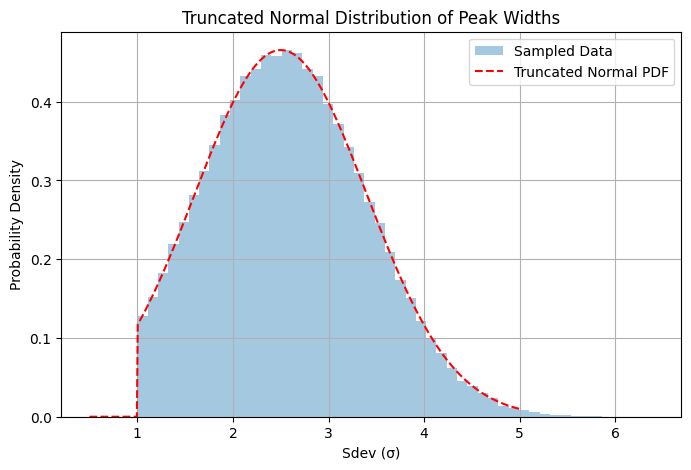

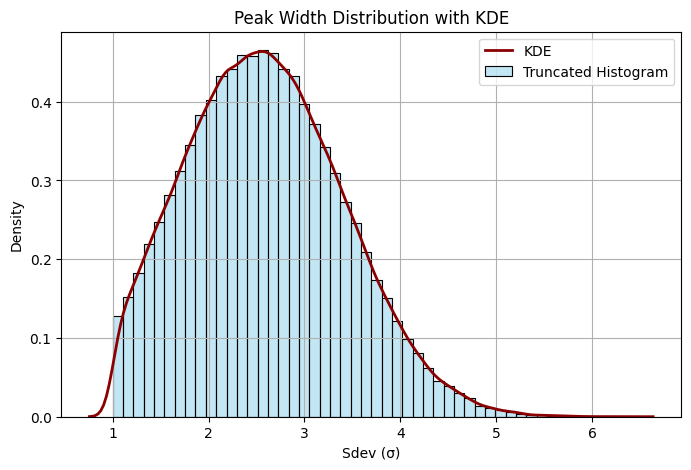

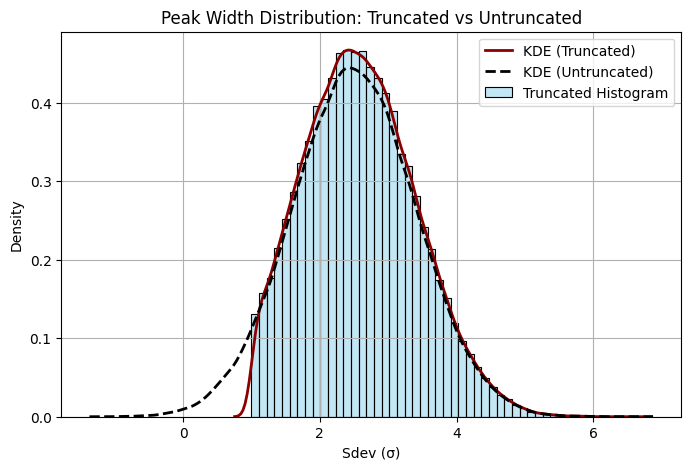

In [80]:
#Prob dist for peak width sdevs
#CLEANED WITH DEFS 

#constants
loc = 2.5
scale = 0.9
MIN_WIDTH = 1.0 #prevents magic numbers 

#create random seed for reproducibility
np.random.seed(42)

#gets truncated samples
def get_truncated_samples(loc=loc, scale=scale, size=100000):
    a = (MIN_WIDTH - loc) / scale
    b = np.inf
    trunc_dist = truncnorm(a=a, b=b, loc=loc, scale=scale)
    return trunc_dist.rvs(size), trunc_dist

#gets normalized truncated samples
def get_truncnorm_samples(loc=loc, scale=scale, size=100000):
    raw = np.random.normal(loc=loc, scale=scale, size=size)
    truncated = raw[raw > MIN_WIDTH]
    return raw, truncated
    

#Plot 1: Truncated dist (PDF Overlay)
def plot_pdf_overlay(samples, trunc_dist):
    x = np.linspace(0.5, 5, 500)
    plt.figure(figsize=(8, 5))
    
    plt.hist(samples, bins=50, density=True, alpha=0.4, label='Sampled Data')
    plt.plot(x, trunc_dist.pdf(x), 'r--', label='Truncated Normal PDF')
    plt.title('Truncated Normal Distribution of Peak Widths')
    plt.xlabel('Sdev (σ)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

#Plot 2: KDE + Histogram 
def plot_kde(samples):
    plt.figure(figsize=(8, 5))
    
    sns.histplot(samples, bins=50, stat='density', color='skyblue', alpha=0.5, label='Truncated Histogram')
    sns.kdeplot(samples, color='darkred', linewidth=2, label='KDE')
    
    plt.title('Peak Width Distribution with KDE')
    plt.xlabel('Sdev (σ)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

#Plot 3: Truncated vs Untruncated Comparison
def plot_comparison(untruncated, truncated):
    plt.figure(figsize=(8, 5))
    
    sns.histplot(truncated, bins=50, stat='density', color='skyblue', alpha=0.5, label='Truncated Histogram')
    sns.kdeplot(truncated, color='darkred', linewidth=2, label='KDE (Truncated)')
    sns.kdeplot(untruncated, color='black', linestyle='--', linewidth=2, label='KDE (Untruncated)')
    
    plt.title('Peak Width Distribution: Truncated vs Untruncated')
    plt.xlabel('Sdev (σ)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

#Run
truncated_samples, trunc_dist = get_truncated_samples()
plot_pdf_overlay(truncated_samples, trunc_dist)
plot_kde(truncated_samples)

raw_samples, trunc_samples = get_truncnorm_samples()
plot_comparison(raw_samples, trunc_samples)


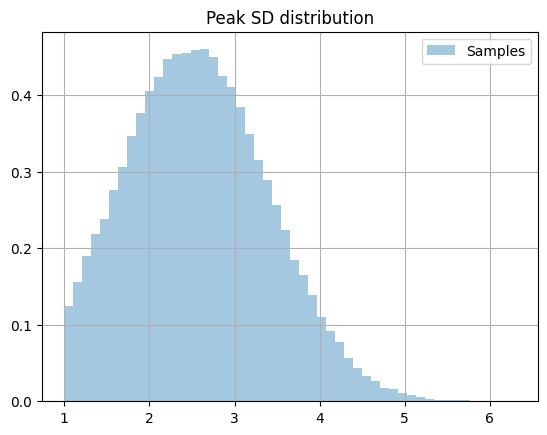

In [81]:
#Mason Levere probabilitity distribution for standard deviations for peak widths

loc = 2.5       # mean
scale = 0.9     # std deviation

# Create distribution

# Sample from it
samples = np.random.normal(loc=loc, scale=scale, size=100000)
samples = samples[samples > 1] #Creates statistical bias from truncation
# Plot
x = np.linspace(0, 5, 500)

plt.hist(samples, bins=50, density=True, alpha=0.4, label='Samples')
plt.legend()
plt.title('Peak SD distribution')
plt.grid(True)
plt.show()


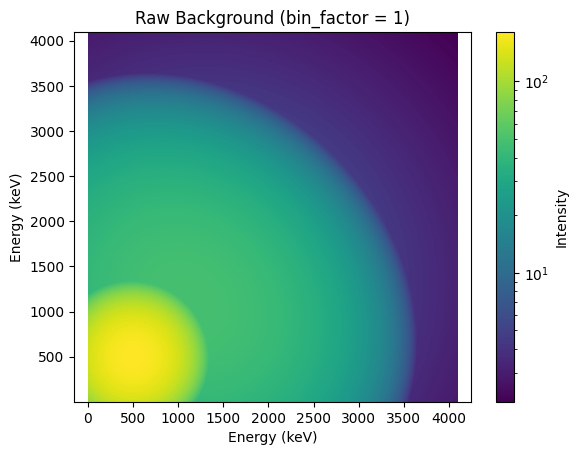

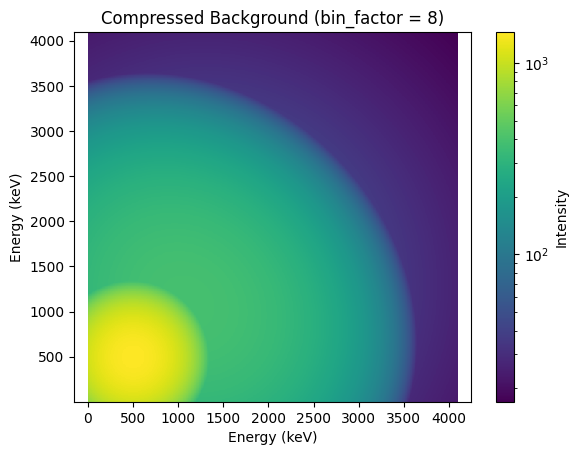

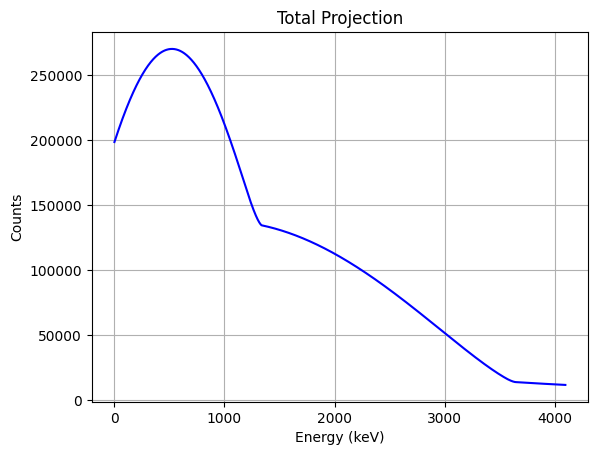

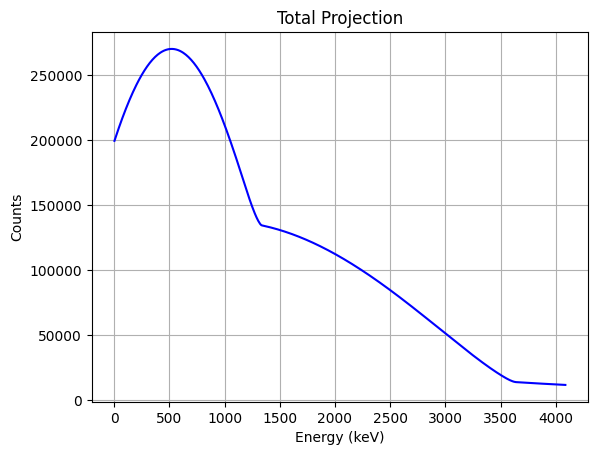

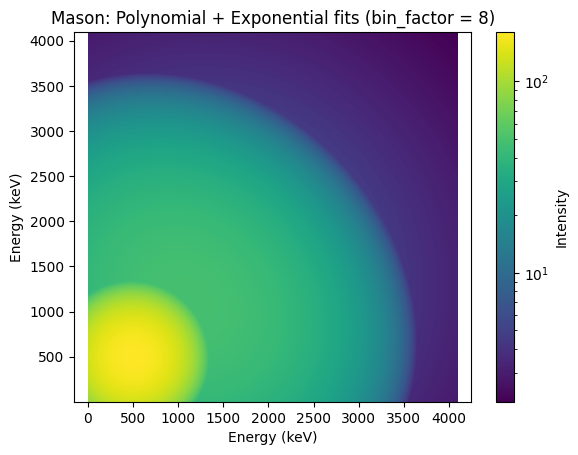

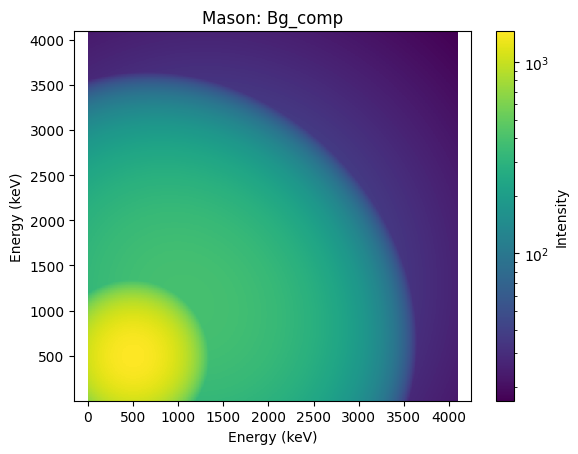

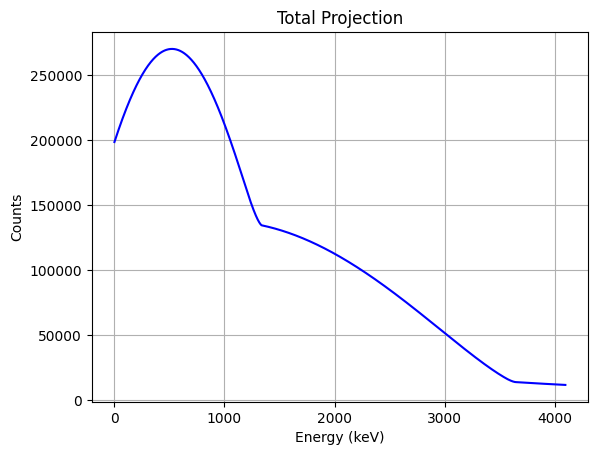

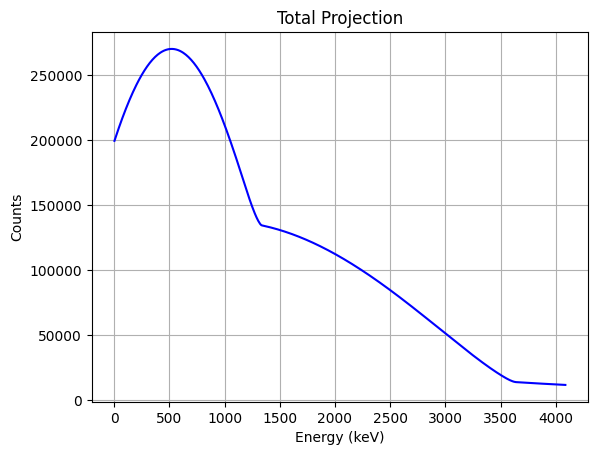

In [105]:
#Background graphing

#constants + parameters
N = 4096
bin_factor = 1
energy_axis = 1.785 + 0.99943 * (np.arange(N) * bin_factor)

#Loads & processes bg matrix
bg = np.load('custombg.npy')
bg_clipped = np.clip(bg, a_min=0, a_max=None)

#Plot original background
def plot_matrix(matrix, title, energy_axis, bin_factor, lognorm=True):
    plt.figure()
    
    norm = LogNorm() if lognorm else None
    
    plt.imshow(
        matrix,
        cmap='viridis',
        norm=norm,
        interpolation='nearest',
        origin='lower',
        extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]]
    )
    plt.colorbar(label="Intensity")
    plt.title(f"{title} (bin_factor = {bin_factor})")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Energy (keV)")
    plt.axis('equal')
    plt.show()

plot_matrix(bg, title="Raw Background", energy_axis=energy_axis, bin_factor=bin_factor)

# --- Compress and plot background ---
bin_factor = 8  # Overwrites the earlier value
bg_comp = compress_matrix(bg, bin_factor=bin_factor)

plot_matrix(bg_comp, title="Compressed Background", energy_axis=energy_axis, bin_factor=bin_factor)

#Project total signal
TotalProjection(bg)
TotalProjection(bg_comp, bin_factor=bin_factor)

##MASON GRAPH COMPARISON ###
plt.imshow(bg, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
plt.colorbar(label="Intensity")
plt.title(f"Mason: Polynomial + Exponential fits (bin_factor = {bin_factor})")
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (keV)")
plt.axis('equal')
plt.show()

###MASON GRAPH COMPARISON ###
plt.figure()
plt.imshow(bg_comp, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
plt.colorbar(label="Intensity")
plt.title(f"Mason: Bg_comp")
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (keV)")
plt.axis('equal')
plt.show()


TotalProjection(bg)
TotalProjection(bg_comp, bin_factor=bin_factor)

In [ ]:
#Mason: Runs and checks 1 trial at a time

# dim controls the dimension of the matrix
# max_rungs controls the amount of states in each normal band
# num_ladders controls the amount of bands in the data

seed = 10
dim = 512
bin_factor = 4096//dim
max_rungs = 3
num_ladders = random.randint(3, 5)


def index_to_energy(index, bin_factor=bin_factor):
    return (1.785 + (0.99943 * (index * bin_factor)))
def add_poisson_noise(background, scale=1):
    noisy_background = ((np.random.poisson(lam=np.clip(background, 0, None)) - background) * scale) + background
    upper = np.triu(noisy_background)
    matrix = upper + upper.T - np.diag(np.diag(noisy_background))
    return matrix

def add_gaussian_noise(matrix, mean=0, std=1):
    mask = matrix != 0  # only apply noise to non-zero elements
    matrix = matrix.astype(np.float64) 
    noisy_matrix = matrix.copy()
    noise = np.random.normal(mean, std, size=matrix.shape)
    noisy_matrix[mask] += noise[mask]
    return noisy_matrix

bg_comp = compress_matrix(bg, bin_factor=bin_factor)


N = 4096//bin_factor
#energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))




def simulate_2D_matrix(seed, max_rungs, bin_factor=1, cutoff_sigma=10, plot=True, num_ladders=1):
    rng_np = np.random.default_rng(seed)
    rng_py = random.Random(seed)
    start_time = time.perf_counter()

    def scaled_index_to_energy(index):
        return 1.785 + (0.99943 * (index * bin_factor))

    
    count_lst = []
    count_lst2 = []
    N_full = 4096
    N = N_full // bin_factor
    energy_axis = 1.785 + (0.99943 * (np.arange(N) * bin_factor))
    X, Y = np.meshgrid(energy_axis, energy_axis)
    matrix = np.zeros((N, N), dtype=np.float32)
    
    # number of peaks in a matrix (can be fixed)
    peak_index, peak_height, peak_width = peak_ladder(num_ladders, 0.02, max_rungs, threshold=0.3) #3 is number of rungs per band segment)
    peak_index_parameter, peak_height_parameter, peak_width_parameter = TwoDParamaters(peak_index, peak_height, peak_width)

    peak_index_ls = [
    [scaled_index_to_energy(i // bin_factor) for i in sublist]
    for sublist in peak_index
]


    scaled_index = [(i[0] // bin_factor, i[1] // bin_factor) for i in peak_index_parameter]
    scaled_width = peak_width_parameter

    centers_x = [scaled_index_to_energy(t[0]) for t in scaled_index]
    centers_y = [scaled_index_to_energy(t[1]) for t in scaled_index]
    sigmas_x = [t[0] for t in scaled_width]
    sigmas_y = [t[1] for t in scaled_width]


    amplitudes = peak_height_parameter
    #print(sigmas_x, sigmas_y)

    for x0, y0, sx, sy, A in zip(centers_x, centers_y, sigmas_x, sigmas_y, amplitudes):
        #print(x0, y0, sx, sy, A)
        #print(x0)
        
        A *= 1
        #sx = 6
        #sy = 6



        xmin = max(0, np.searchsorted(energy_axis, x0 - cutoff_sigma * sx))
        xmax = min(N, np.searchsorted(energy_axis, x0 + cutoff_sigma * sx))
        ymin = max(0, np.searchsorted(energy_axis, y0 - cutoff_sigma * sy))
        ymax = min(N, np.searchsorted(energy_axis, y0 + cutoff_sigma * sy))

        if xmax <= xmin or ymax <= ymin:
            continue
            
        mean = [x0, y0]
        cov = [[sx**2, 0], [0, sy**2]]

        
        rv = multivariate_normal(mean, cov)

        X_sub = X[ymin:ymax, xmin:xmax]
        Y_sub = Y[ymin:ymax, xmin:xmax]
        
        pos = np.dstack((X_sub, Y_sub))

        G = rv.pdf(pos)
        G = (G / np.sum(G)) * A
        #TwoDPlot(G, title='G')
        

        count_lst.append(np.sum(G))

        
        matrix[ymin:ymax, xmin:xmax] += G.astype(np.float32)
        dx = np.mean(np.diff(energy_axis))
        dy = dx  # assuming square bins

# Then scale your numerical sum:
        


    matrix *= 1 # for scaling with bg
    matrix += 0  # Prevent log(0) in plot
    #print('amp', amplitudes)
    #print('counts', count_lst)
    #print('2', count_lst2)

    if plot:
        plt.imshow(matrix, cmap='viridis', norm=LogNorm(), interpolation='nearest', origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
        plt.colorbar(label="Intensity")
        plt.title(f"2D Gaussian Matrix with Energy Axis (bin_factor = {bin_factor})")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Energy (keV)")
        plt.axis('equal')
        plt.show()

    level_scheme = band_maker(peak_index_ls, bin_factor)



    return(matrix, level_scheme)







matrix, level_scheme = simulate_2D_matrix(seed, max_rungs, bin_factor=bin_factor, num_ladders=num_ladders, cutoff_sigma=10)

matrix = matrix * 6

TotalProjection(matrix, bin_factor=bin_factor)

#bgcp = np.maximum(add_poisson_noise(bgcquad, scale=4), add_poisson_noise(bgcexp, scale=4))
bgcp = (add_poisson_noise(bg_comp, scale=10))

# Apply Gaussian smearing with std = sqrt(n)

#bgcp = (bgn + np.random.normal(0,  np.sqrt(bgn)) ) / shrink
bgcp = np.clip(bgcp, 0, None)


#bgcg = add_gaussian_noise(bgcp, std=20)



TotalProjection(bg, 0, title = 'Background', bin_factor=1)

TotalProjection(bgcp, 0, title = 'Poisson noise', bin_factor=bin_factor)
#TotalProjection(bgcg, 0, title = 'Gaussian + Poisson Total Projection', bin_factor=bin_factor)


matrix_bg = np.clip(add_poisson_noise(matrix + bgcp), a_min=1, a_max=None)


plot_level_bands(level_scheme)

TotalProjection(matrix_bg, bin_factor=bin_factor, prominence=1e4)

plt.figure()
TwoDPlot(bg_comp, 'Full Background', bin_factor)
plt.figure()
TwoDPlot(bgcp, 'Background with noise', bin_factor)
plt.figure()
TwoDPlot(matrix_bg, 'Background with noise + Signal', bin_factor)


In [106]:
#Ace: Runs and checks 1 trial at a time
#Constants
CALIB_OFFSET = 1.785
CALIB_SLOPE = 0.99943
FULL_DIM = 4096

#Configuration class 
class SimulationConfig:
    #stores/computes configuration for matrix simulations
    def __init__(self, seed=10, dim=512, max_rungs=3):
        self.seed = seed
        self.dim = dim
        self.bin_factor = FULL_DIM // dim
        self.max_rungs = max_rungs
        self.num_ladders = random.randint(3, 5)
        self.energy_axis = self.compute_energy_axis()

    #generate energy axis based on binning
    def compute_energy_axis(self):
        N = FULL_DIM // self.bin_factor
        dummy1 = CALIB_OFFSET + CALIB_SLOPE
        dummy2 = np.arange(N)
        dummy3 = dummy1 * dummy2
        return dummy3
        
        range(N) * self.bin_factor

    #convert array index to energy using bin factor
    def index_to_energy(self, index):
        return CALIB_OFFSET + CALIB_SLOPE * index * self.bin_factor

#Adds scaled Poisson noise to a symmetric matrix
def add_poisson_noise(background, scale=1):
    noisy_background = ((np.random.poisson(lam=np.clip(background, 0, None)) - background) * scale) + background
    upper = np.triu(noisy_background)
    return upper + upper.T - np.diag(np.diag(noisy_background))

#add gaussian noise to non zero elements 
def add_gaussian_noise(matrix, mean=0, std=1):
    mask = matrix != 0
    matrix = matrix.astype(np.float64)
    #noisy_matrix = matrix.copy()
    noise = np.random.normal(mean, std, size=matrix.shape)
    matrix[mask] += noise[mask]
    return matrix

#Generates synthetic 2D Gaussian matrix w/simulated peak structure and energy calibration
def simulate_2D_matrix(seed, max_rungs, bin_factor=1, cutoff_sigma=10, plot=True, num_ladders=1):
    rng_np = np.random.default_rng(seed)
    rng_py = random.Random(seed)
    #N_full = 4096
    N = FULL_DIM // bin_factor
    #energy axis
    energy_axis = CALIB_OFFSET + CALIB_SLOPE * np.arange(N) * bin_factor
    X, Y = np.meshgrid(energy_axis, energy_axis)
    matrix = np.zeros((N, N), dtype=np.float32)

    #Generate peak parameters
    peak_index, peak_height, peak_width = peak_ladder(num_ladders, 0.02, max_rungs, threshold=0.3)
    peak_index_param, peak_height_param, peak_width_param = TwoDParamaters(peak_index, peak_height, peak_width)

    peak_index_ls = [
        [CALIB_OFFSET + CALIB_SLOPE * (i // bin_factor) * bin_factor for i in sublist]
        for sublist in peak_index]
    scaled_index = [(i[0] // bin_factor, i[1] // bin_factor) for i in peak_index_param]
    
    centers_x = [CALIB_OFFSET + CALIB_SLOPE * t[0] * bin_factor for t in scaled_index]
    centers_y = [CALIB_OFFSET + CALIB_SLOPE * t[1] * bin_factor for t in scaled_index]
    sigmas_x = [t[0] for t in peak_width_param]
    sigmas_y = [t[1] for t in peak_width_param]
    amplitudes = peak_height_param

    #Add Gaussians
    for x0, y0, sx, sy, A in zip(centers_x, centers_y, sigmas_x, sigmas_y, amplitudes):
        xmin = max(0, np.searchsorted(energy_axis, x0 - cutoff_sigma * sx))
        xmax = min(N, np.searchsorted(energy_axis, x0 + cutoff_sigma * sx))
        ymin = max(0, np.searchsorted(energy_axis, y0 - cutoff_sigma * sy))
        ymax = min(N, np.searchsorted(energy_axis, y0 + cutoff_sigma * sy))

        if xmax <= xmin or ymax <= ymin:
            continue

        mean = [x0, y0]
        cov = [[sx**2, 0], [0, sy**2]]
        rv = multivariate_normal(mean, cov)

        X_sub = X[ymin:ymax, xmin:xmax]
        Y_sub = Y[ymin:ymax, xmin:xmax]
        pos = np.dstack((X_sub, Y_sub))
        
        G = rv.pdf(pos)
        G = (G / np.sum(G)) * A
        matrix[ymin:ymax, xmin:xmax] += G.astype(np.float32)

    #matrix += 0  # avoids log(0)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.imshow(matrix, cmap='viridis', norm=LogNorm(), origin='lower',
                   extent=[energy_axis[0], energy_axis[-1], energy_axis[0], energy_axis[-1]])
        plt.colorbar(label="Intensity")
        plt.title(f"2D Gaussian Matrix (bin_factor = {bin_factor})")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Energy (keV)")
        plt.axis('equal')
        plt.show()

    level_scheme = band_maker(peak_index_ls, bin_factor)
    return matrix, level_scheme

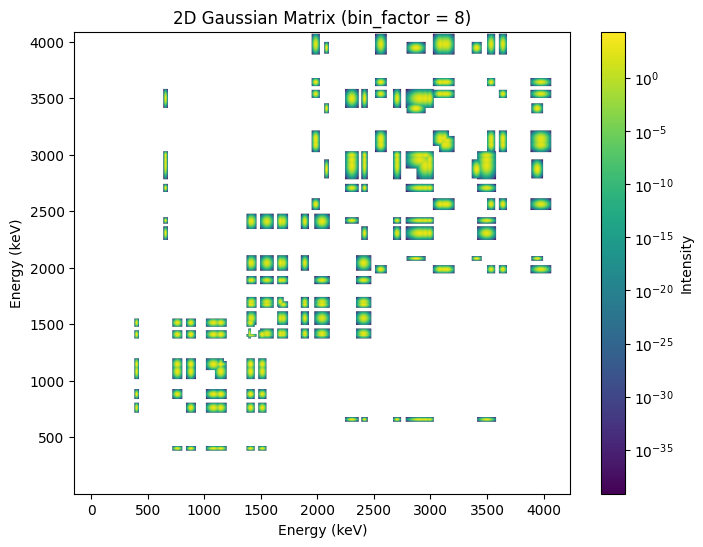

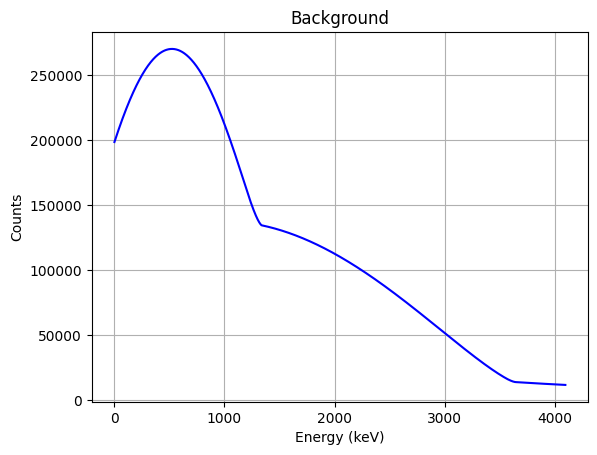

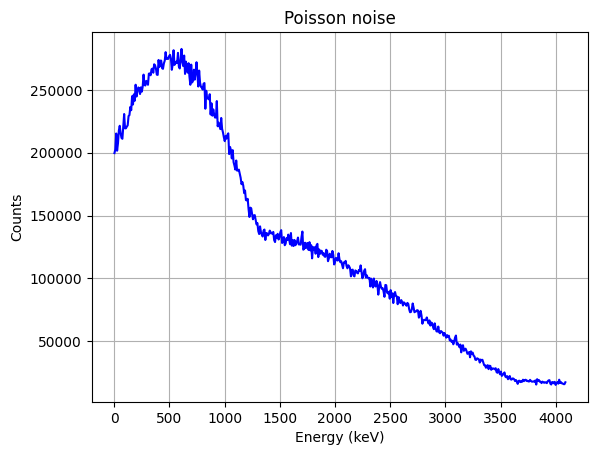

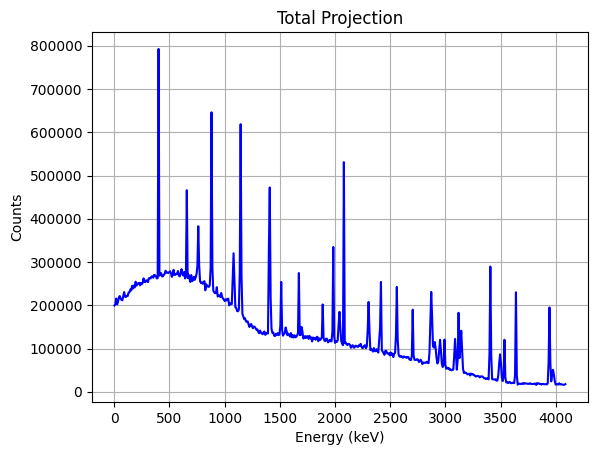

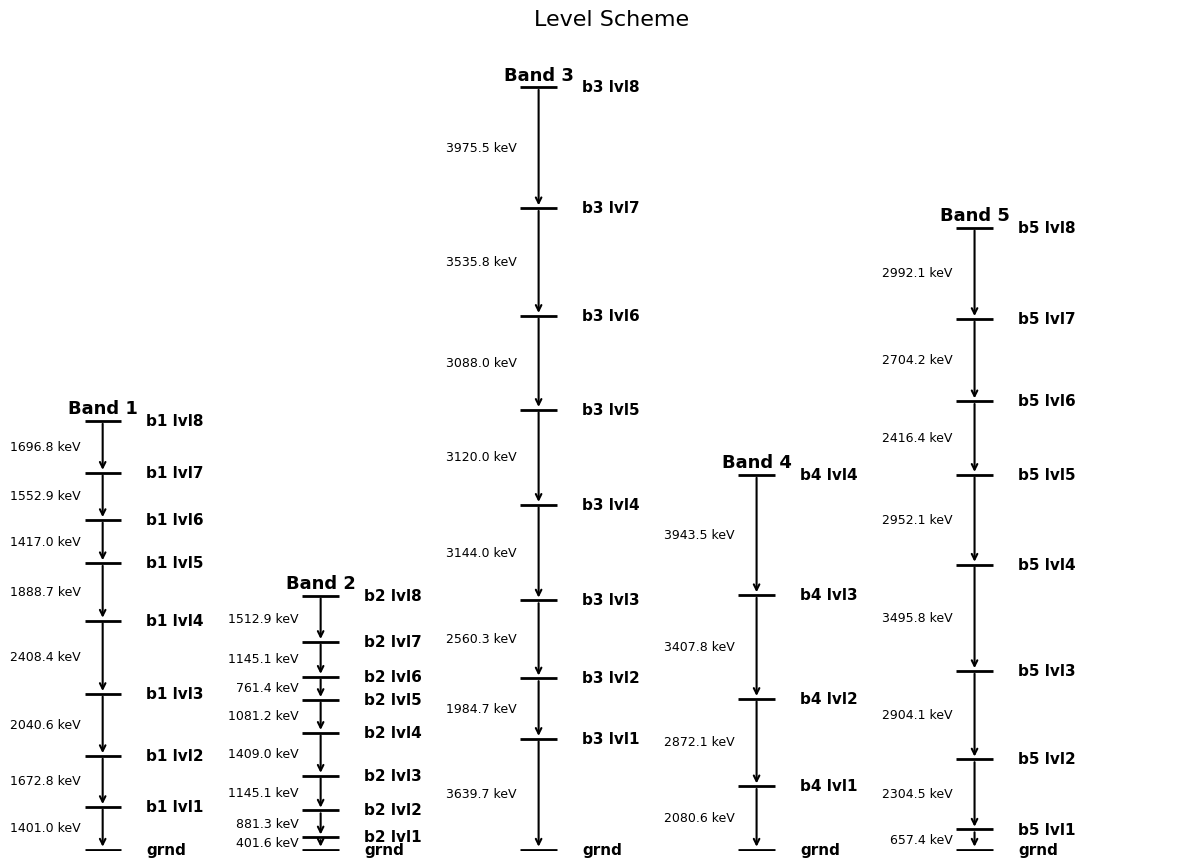

<Figure size 640x480 with 0 Axes>

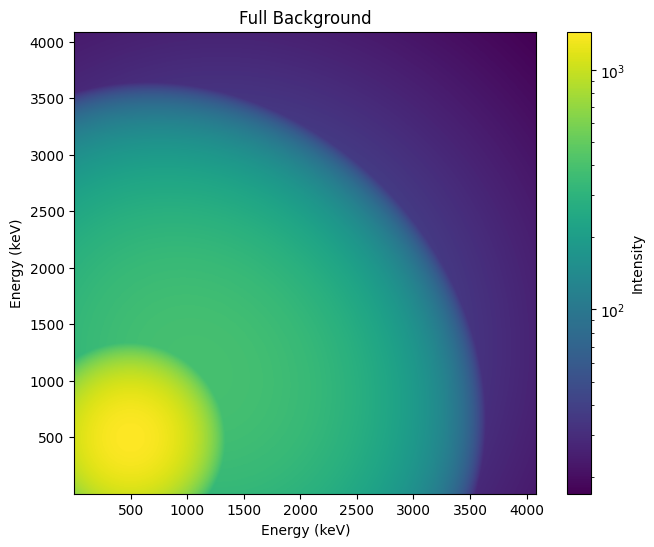

<Figure size 640x480 with 0 Axes>

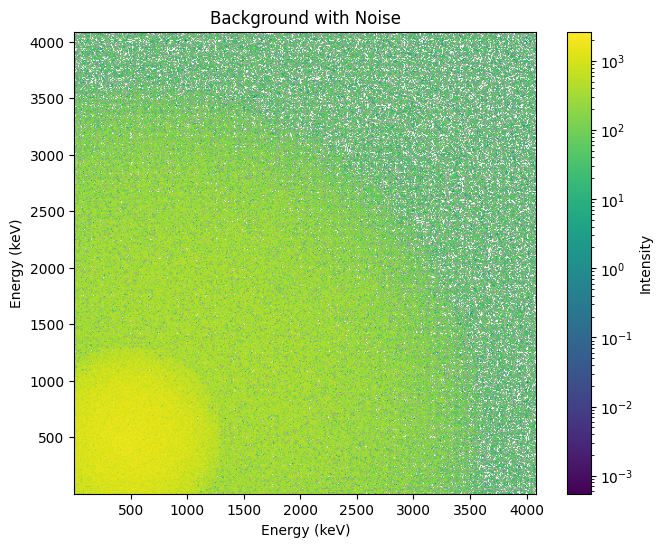

<Figure size 640x480 with 0 Axes>

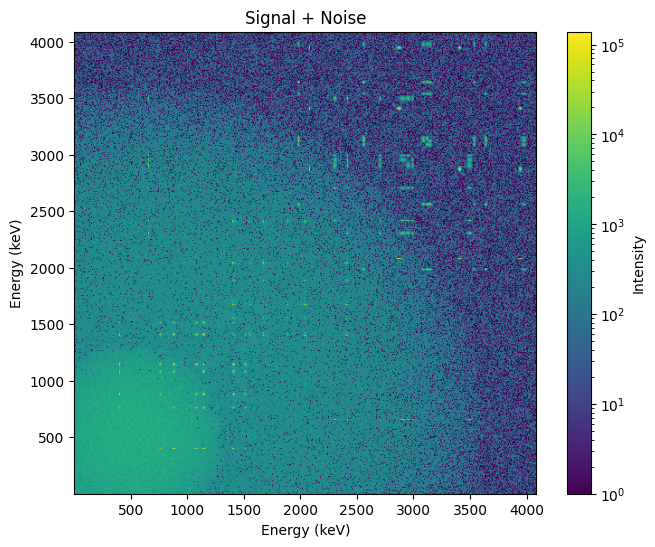

In [107]:
#simulation
cfg = SimulationConfig(seed=seed, dim=dim, max_rungs=max_rungs)
bin_factor = cfg.bin_factor
num_ladders = cfg.num_ladders

#Load and compress background
bg = np.load('custombg.npy')
bg_comp = compress_matrix(bg, bin_factor=bin_factor)

#Simulate synthetic matrix
matrix, level_scheme = simulate_2D_matrix(
    seed=cfg.seed,
    max_rungs=cfg.max_rungs, 
    bin_factor=cfg.bin_factor, 
    #cutoff_sigma=10, 
    #plot=True, 
    num_ladders=num_ladders
)

matrix *= 6  #scale intensity

#Add Poisson noise to background
bgcp = add_poisson_noise(bg_comp, scale=10)
bgcp = np.clip(bgcp, a_min=0, a_max=None)

#Combine signal + noise
matrix_bg = matrix + bgcp
matrix_bg = add_poisson_noise(matrix_bg)
matrix_bg = np.clip(matrix_bg, a_min=1, a_max=None)

#1D projections + level scheme
#def TotalProjection(matrix, bin_factor, title)
TotalProjection(bg, bin_factor=1, title='Background')
TotalProjection(bgcp, bin_factor=bin_factor, title='Poisson noise')
TotalProjection(matrix_bg, bin_factor=bin_factor, prominence=1e4)
plot_level_bands(level_scheme)

#2D projections
'''
#def TwoDPlot(matrix, bin_factor, title)
plt.figure()
TwoDPlot(bg_comp, bin_factor, 'Full Background')
plt.figure()
TwoDPlot(bgcp, bin_factor, 'Background with noise')
plt.figure()
TwoDPlot(matrix_bg, bin_factor, 'Background with noise + Signal')
plt.show()
'''
for mat, title in [
    (bg_comp, 'Full Background'),
    (bgcp, 'Background with Noise'),
    (matrix_bg, 'Signal + Noise')
]:
    plt.figure()
    TwoDPlot(mat, bin_factor=bin_factor, title=title)

plt.show()

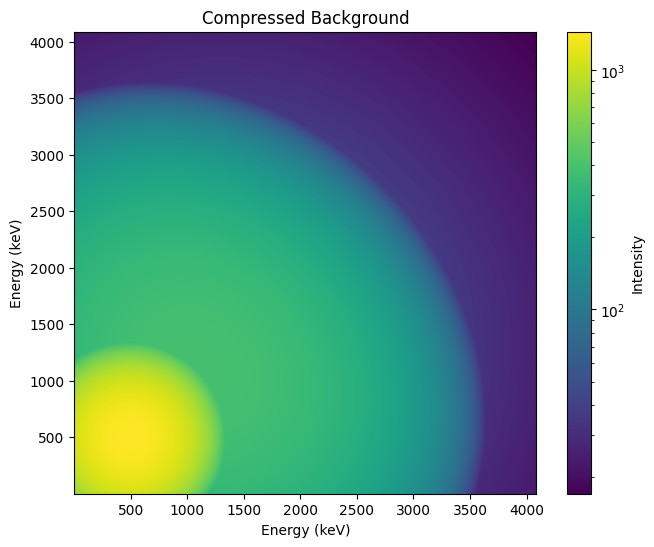

512
Running 100 simulations with dim=512, bin_factor=8


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [115]:
# this cell executes the simulation data and saves it to a .npz file
# a custom name of the file can be chosen, by default it includes the max_rungs and dim_actual parameters in the name

#Variable definitions
num_sims = 100
max_rungs = 3
dim_pref = 512
bin_factor = 4096 // dim_pref
dim_actual = 4096 // bin_factor

#load bg & check plot
bgcompressed = compress_matrix(bg, bin_factor=bin_factor)
TwoDPlot(bgcompressed, bin_factor, 'Compressed Background')

#run simulation
sims = {}
start_time = time.time()
print(dim_actual)
print(f"Running {num_sims} simulations with dim={dim_actual}, bin_factor={bin_factor}")

for i in range(num_sims):
    sim_start = time.time()

    #randomize # of ladders
    num_ladders = random.randint(3,5)

    #toy/synthetic matrix
    matrix, level_scheme = simulate_2D_matrix(
        seed=seed, 
        max_rungs=max_rungs, 
        bin_factor=bin_factor, 
        num_ladders=num_ladders, 
        cutoff_sigma=10, 
        plot=False
    )
    matrix *= 6 #scale intensity 

    #background poisson noise
    bgcp = np.clip((add_poisson_noise(bgcompressed, scale=6), 0, None))
    #bgcp = np.clip(bgcp, 0, None)

    #background + signal, clip low counts
    matrix_bg = np.clip(add_poisson_noise(matrix + bgcp), a_min=1, a_max=None)

    #save results
    sims[f'matrix_{i}'] = matrix_bg
    sims[f'level_scheme_{i}'] = level_scheme

    #print timing info 
    sim_time = time.time() - sim_start
    #elapsed_time = end_time - start_time_i
    print(f"Simulation {i+1}/{num_sims} completed in {sim_time:.2f} seconds")

#save results
total_time = time.time() - start_time
print(f"Total elapsed time: {total_time:.2f} seconds")

filename = f'simulation_results{max_rungs}r{dim_actual}x_custombg.npz'
np.savez(filename, **sims)
print(f"Results saved to {filename}")



In [114]:
# how to unpack data

data = np.load('simulation_results3r512x_custombg.npz', allow_pickle=True)

matrix_0 = data['matrix_0']

matrix_keys = [k for k in data.files if k.startswith('matrix_')]
matrix_list = [data[k] for k in matrix_keys]

level_scheme_keys = [k for k in data.files if k.startswith('level_scheme_')]
level_scheme_list = [data[k] for k in level_scheme_keys]




FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results3r512x_custombg.npz'

In [112]:
print(bin_factor)

8


In [111]:
# viewing simulation results

for i in range(0, 10): # increase end of range to view more
    x = matrix_list[i]
    y = level_scheme_list[i]
    TwoDPlot(x, title = f'Simulation {i+1}', bin_factor=bin_factor)
    plot_level_bands(y)
    TP = TotalProjection(x, 1, bin_factor=bin_factor, prominence=4e3)
    plt.figure()




NameError: name 'matrix_list' is not defined

In [ ]:
TotalProjection(background, bin_factor=1)


In [ ]:

background_filtered2 += 0

TotalProjection(background_filtered2, bin_factor=1)


In [ ]:
from scipy.ndimage import correlate1d
correlate1d([2, 8, 0, 4, 1, 9, 9, 0], weights=[1, 3])


In [ ]:
from scipy.ndimage import convolve1d

input_array = [2, 8, 0, 4, 1]
kernel = [1, 3]

result = convolve1d(input_array, kernel)
print(result)

In [ ]:
np.uint32(10*(np.random.normal(1, .2, 4096)))